# Práctica 6.5. Clasificación de textos con transformers de Hugging Face (🤗)

Esta práctica está basada en la cuarta sesión del fantástico curso [NLP de 0 a 100](https://nlp-en-es.org/nlp-de-cero-a-cien/sesion-04), organizado por [NLP en ES](https://nlp-en-es.org/), Spain AI y Hugging Face, e impartido por Lewis Tunstall.

Aquí veremos cómo usar la API de Hugging Face, descargar un dataset, un modelo pre-entrenado (RoBERTa en español) y hacer fine-tuning para clasificar las reseñas de Amazon.

## 1. Instalación del entorno Hugging Face

Si estás ejecutando este notebook en Google Colab, ejecuta la siguiente celda para instalar la biblioteca de transformers que necesitamos. Esto instalará el entorno de Hugging Face (también conocido con el emoticono 🤗). Si estás en un entorno en tu equipo local, lanza la instrucción en una Terminal.

In [1]:
!pip install transformers datasets

     |████████████████████████████████| 3.4 MB 26.9 MB/s 
     |████████████████████████████████| 306 kB 71.3 MB/s 
     |████████████████████████████████| 596 kB 69.9 MB/s 
     |████████████████████████████████| 895 kB 79.4 MB/s 
     |████████████████████████████████| 3.3 MB 55.9 MB/s 
     |████████████████████████████████| 67 kB 7.6 MB/s 
     |████████████████████████████████| 1.1 MB 69.2 MB/s 
     |████████████████████████████████| 133 kB 80.2 MB/s 
     |████████████████████████████████| 243 kB 77.1 MB/s 
     |████████████████████████████████| 160 kB 70.5 MB/s 
     |████████████████████████████████| 271 kB 79.9 MB/s 
     |████████████████████████████████| 144 kB 61.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## 2. Carga y exploración del dataset

Utilizaremos 🤗 Datasets para cargar y procesar nuestro conjunto de datos. Si quieres saber más sobre los 🤗 Datasets, visualiza el siguiente vídeo (en inglés).




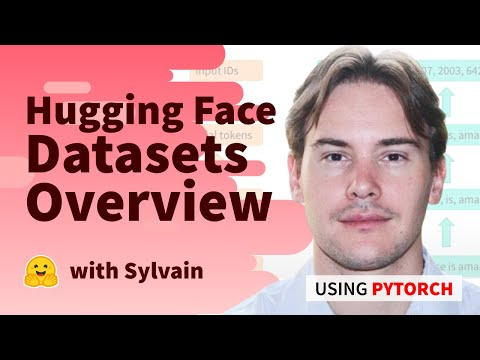

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo("_BZearw7f0w", width=600, height=400)

En la siguiente celda vamos a descargar el dataset de amazon reviews, en español (parámetro "es"). Esto descarga un objeto que es un diccionario, donde las claves son los subconjuntos del dataset (train, val y train). También podrás ver las características (columnas) del dataset), y el número de ejemplos (filas).

In [3]:
# importamos la librería de datasets
from datasets import load_dataset

# descargamos el dataset de amazon reviews en español
dataset = load_dataset("amazon_reviews_multi", "es")
# veamos la distribución del dataset
dataset

Downloading:   0%|          | 0.00/2.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/77.5M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

Ahora vamos a hacer una pequeña muestra aleatoria del conjunto de entrenamiento, para tener una idea de la forma que tienen los ejemplos. Podrás ver que hay un id de review, de producto, de reviewer, el número de estrellas (de menos a más satisfecho, de 1 a 5) y el contenido de la review. La idea va a ser intentar predecir el número de estrellas a partir de la review.

In [4]:
import random
import pandas as pd
from datasets import ClassLabel
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    "Está función está sacada de https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb"
    
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(dataset["train"])

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0761677,product_es_0357752,reviewer_es_0125702,2,Lo he probado 2 veces.A la tercera ....suena más mi móvil que este aparato!,Simple,es,home_improvement
1,es_0951419,product_es_0013500,reviewer_es_0094895,5,"Estoy muy contento con los diferentes tipos de henna para hacer tattoos ya que puedes coger diferentes colores y diferentes duraciones en la piel, a demás también lleva una serie de accesorios para poder disfrutar más de la realización de estos rayos. Yo me hago mis propias planillas y las pongo encima de la piel y a dibujar.",Variedad de henna,es,beauty
2,es_0915481,product_es_0759284,reviewer_es_0030510,4,"Es perfecto para ese modelo,hay otros que no coincide por la posición en la que está la cámara,este es el mejor que he encontrado",Válido,es,home
3,es_0320168,product_es_0392095,reviewer_es_0213701,1,"Deformado justo por el lado del cierre, no se puede abrir.",Producto dañado.,es,kitchen
4,es_0720645,product_es_0203870,reviewer_es_0796080,3,Buenas noches he abierto hoy el paquete y me dado cuenta que falta la correa para llevar la bolsa colgando por lo demás todo está correcto Un cordial saludo,Falta alguna cosa,es,pc
5,es_0499673,product_es_0064840,reviewer_es_0866577,3,"Es economico y una réplica del original. El boton de encendido y apagado es duro de accionar y no responde a la primera. Sale continuamente un mensaje para que ponga un password, y con el original no pasaba.",Economico,es,electronics
6,es_0194074,product_es_0221060,reviewer_es_0225537,2,"El tamaño es bastante bueno para celebrar lo que necesites. Pero una de las que hemos recibido viene mal, el tamaño de la carpa es menor a la estructura. No sé puede montar",Lo justo,es,lawn_and_garden
7,es_0005263,product_es_0984422,reviewer_es_0724939,5,"Muy buen largo del mango, buen peso, es mi primer safety razor y no me llevo mucho tiempo acostumbrarme, nunca mas una desechable tipo match 3 o esas que salen fortuna los repuestos.",Excelente primer safety razor,es,drugstore
8,es_0234186,product_es_0544545,reviewer_es_0846648,5,Por el precio que tiene esta muy bien y funciona de maravilla tanto con el vino como con la sidra.,Bien en calidad precio,es,home
9,es_0747391,product_es_0801249,reviewer_es_0712883,3,Lo mejor del producto es el diseño. Pero tiene en contra la bateria. Dos dias y sin apenas notificaciones,Bateria,es,sports


Es muy fácil transformar un dataset a un dataframe de Pandas:

In [5]:
dataset.set_format("pandas")
df = dataset["train"][:]
df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [6]:
df["product_category"].value_counts()

home                        26962
wireless                    25886
toy                         13647
sports                      13189
pc                          11191
home_improvement            10879
electronics                 10385
beauty                       7337
automotive                   7143
kitchen                      6695
apparel                      5737
drugstore                    5513
book                         5264
furniture                    5229
baby_product                 4881
office_product               4771
lawn_and_garden              4237
other                        3937
pet_products                 3713
personal_care_appliances     3573
luggage                      3328
camera                       3029
shoes                        2754
digital_ebook_purchase       1843
video_games                  1733
jewelry                      1598
musical_instruments          1530
watch                        1490
industrial_supplies          1482
grocery       

In [7]:
df["stars"].value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

In [8]:
dataset.reset_format()

## 3. Fusionar las clasificaciones por estrellas

Para simplificar, vamos a quitar aquellas reseñas neutrales (3 estrellas), de esta forma conseguiremos que los ejemplos sean dicotómicos (negativo o positivo). Muchas veces la clave está en simplificar el problema.

In [9]:
# Una forma rápida es filtrar usando una función lambda (sin nombre).
dataset = dataset.filter(lambda x : x["stars"] != 3)

  0%|          | 0/200 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Para conseguir que un ejemplo sea positivo (1) o negativo (0), vamos a fusionar los ejemplos de 1 y 2 estrellas, y los de 4 y 5 estrellas.

In [10]:
def merge_star_ratings(examples):
    if examples["stars"] <= 2:
        label = 0
    else:
        label = 1
    return {"labels": label}

In [11]:
dataset = dataset.map(merge_star_ratings)

  0%|          | 0/160000 [00:00<?, ?ex/s]

  0%|          | 0/4000 [00:00<?, ?ex/s]

  0%|          | 0/4000 [00:00<?, ?ex/s]

In [12]:
show_random_elements(dataset["train"], num_examples=3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,labels
0,es_0722687,product_es_0800069,reviewer_es_0513216,5,Rápido en la entrega y sello muy coqueto,Excelente,es,other,1
1,es_0654876,product_es_0133877,reviewer_es_0003231,4,"Es eficaz, barato, y funciona bien. Todo correcto.",recoge migas gracioso,es,kitchen,1
2,es_0690368,product_es_0294400,reviewer_es_0435956,2,A uno no le funciona el micrófono. Por lo demás eran intuitivo y fácil de usar. Pero bueno. No lo compraría otra vez.,Regulero,es,toy,0


## 4. Tokenizar las reseñas

Como hemos visto hasta ahora, no se le pasa la frase al completo al modelo, sino que se parte en tokens. La tokenización de las reseñas se basa en un modelo pre-entrenado. Puedes seleccionar un modelo en el [Hugging Face Hub](https://huggingface.co/models) (puedes filtrar por la tarea o problema del modelo, lenguaje, etc.). En este caso, vamos a usar Roberta, un modelo de lenguaje en español entrenado en el BSC. Indicamos su nombre de checkpoint como se indica en 🤗 Hub, y descargamos el tokenizador asociado a ese modelo.

In [13]:
from transformers import AutoTokenizer

model_checkpoint = "BSC-TeMU/roberta-base-bne"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Vamos a aplicar la tokenización a las reseñas. De momento vamos a jugar con un ejemplo.


In [15]:
# El tamaño del vocabulario del tokenizador
tokenizer.vocab_size

50262

En el siguiente ejemplo puedes ver algunos tokens especiales (como el comienzo `<s>` y fin `</s>`) y que algunas palabras, como lewis, al no ser común en español, se ha partido en dos tokens (esto lo hace el algoritmo intentando maximizar los tokens conocidos). Un token desconocido sería `<UNK>`.

In [16]:
# Un ejemplo del codificar y descodificar.
text = "¡hola, me llamo lewis!"
tokenized_text = tokenizer.encode(text)

for token in tokenized_text:
    print(token, tokenizer.decode([token]))

0 <s>
1465 ¡
12616 hola
66 ,
503  me
17111  llamo
532  le
19514 wis
55 !
2 </s>


A continuación podemos visualizar los tensores obtenidos en TensorFlow. Se pueden ver los ids dados a cada token.

In [43]:
encoded_text = tokenizer(text, return_tensors="tf")
encoded_text

{'input_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[    0,  1465, 12616,    66,   503, 17111,   532, 19514,    55,
            2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

Vamos a definir una función que reciba un ejemplo, vaya a la columna del review, y aplique el tokenizador. Vamos a aplicar `truncation=true` para recortar los textos demasiados grandes. Recuerda, los modelos pre-entrenados traducen los textos de entrada a vectores de tamaño fijo, por lo que hay que cortar aquellos ejemplos que sean demasiado grandes.

In [18]:
def tokenize_reviews(examples):
    return tokenizer(examples["review_body"], truncation=True)

In [19]:
columns = dataset["train"].column_names
columns.remove("labels")
# map es como apply de pandas.
# remove_columns es opcional, pero simplifica. Quitará las columnas que no queremos.
encoded_dataset = dataset.map(tokenize_reviews, batched=True, remove_columns=columns)
encoded_dataset

  0%|          | 0/160 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 4000
    })
})

Lo siguiente es una muestra el input del modelo. Como el modelo es del tipo fill mask ("predice la palabra que falta"), hay que indicarle un attention mask. En este caso la entrada se reciba entera (todo 1). Los input_ids son los tokens y el label es la clasificación.

In [20]:
# Esto será el input del modelo
encoded_dataset["train"][0]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'input_ids': [0,
  10626,
  3383,
  361,
  503,
  847,
  36181,
  4747,
  334,
  1111,
  313,
  1369,
  1635,
  342,
  403,
  1594,
  4162,
  2957,
  369,
  10925,
  2],
 'labels': 0}

## 5. Cargar el modelo preentrenado

Desde el módulo de modelos de secuencias (SequenceClassification), descargamos el modelo con el nombre que hemos indicado arriba (el pre-entrenado seleccionado del hub). Indicamos que queremos el modelo para hacer clasificación con dos etiquetas (esta última capa es la que entrenaremos).

In [21]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at BSC-TeMU/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at BSC-TeMU/roberta-base-bne and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj

Si le pasamos el primer ejemplo en encoded_text, obtenemos los logits (lo que luego será 0 o 1).

In [22]:
outputs = model(**encoded_text)
outputs

SequenceClassifierOutput([('logits',
                           tensor([[ 0.0865, -0.0407]], grad_fn=<AddmmBackward0>))])

## 6. Definir las métricas de rendimiento

Definimos una métrica, usaremos accuracy, ya que tenemos un dataset balanceado.

In [23]:
from datasets import load_metric 

metric = load_metric("accuracy")
metric

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions: Predicted labels, as returned by a model.
    references: Ground truth labels.
    normalize: If False, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    sample_weight: Sample weights.
Returns:
    accuracy: Accuracy score.
Examples:

    >>> accuracy_metric = datasets.load_metric("accuracy")
    >>> results = accuracy_metric.compute(references=[0, 1], predictions=[0, 1])
    >>> print(results)
    {'accuracy': 1.0}
""", stored examples: 0)

Esta función se usará para calcular la métrica durante el entrenamiento.

In [24]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## 7. Afinar el modelo preentrenado

Si quieres entender más profundamente cómo funciona el Entrenador de Hugging Face, visualiza el siguiente vídeo:

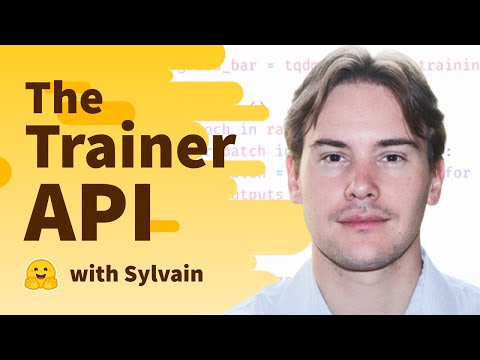

In [25]:
YouTubeVideo("nvBXf7s7vTI", width=600, height=400)

Trainer te permite hacer cosas muy avanzadas (incluso 

In [27]:
from transformers import TrainingArguments

model_name = model_checkpoint.split("/")[-1]

batch_size = 16  # importante, el batch size
num_train_epochs=2  # número de épocas, 2 para ir más rápido
num_train_samples = 20_000 # podemos indicar el número de ejemplos a usar, ya que el dataset es muy grande, usaremos solo 20000
train_dataset = encoded_dataset["train"].shuffle(seed=42).select(range(num_train_samples))
logging_steps = len(train_dataset) // (2 * batch_size * num_train_epochs)

training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=num_train_epochs,     
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    logging_steps=logging_steps
    
    # las siguientes líneas te permiten publicar el modelo en el Hub. Ve al final para ver como.
    #push_to_hub=True,
    #push_to_hub_model_id=f"{model_name}-finetuned-amazon_reviews_multi"
)

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-7648077bd3067874.arrow


Aquí instanciamos el Trainer, indicando nuestro train dataset y la validación, además del tokenizer. Y finalmente, entrenamos.

In [28]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer
)

In [29]:
trainer.train()

***** Running training *****
  Num examples = 20000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.202400,0.169585,0.931000
2,0.091800,0.223374,0.936750


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to results/checkpoint-1250
Configuration saved in results/checkpoint-1250/config.json
Model weights saved in results/checkpoint-1250/pytorch_model.bin
tokenizer config file saved in results/checkpoint-1250/tokenizer_config.json
Special tokens file saved in results/checkpoint-1250/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to results/checkpoint-2500
Configuration saved in results/checkpoint-2500/config.json
Model weights saved in results/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in results/checkpoint-2500/tokenizer_config.json
Special tokens file saved in results/checkpoint-2500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/checkpoint-2500 (score: 0.93675).


TrainOutput(global_step=2500, training_loss=0.16349438664913177, metrics={'train_runtime': 830.1141, 'train_samples_per_second': 48.186, 'train_steps_per_second': 3.012, 'total_flos': 2204961088342080.0, 'train_loss': 0.16349438664913177, 'epoch': 2.0})

Guardamos nuestro dataset en un directorio para nosotros. También lo podemos publicar en el hub (mira el final).

In [37]:
dir="amazon_review"
model.save_pretrained(save_directory=dir)

Configuration saved in amazon_review/config.json
Model weights saved in amazon_review/pytorch_model.bin


Vamos a usar un `pipeline`, que nos permite usar un modelo end-to-end, es decir, directamente pasarle texto y que nos indique la clasificación (automáticamente, sin tener que hacer los pasos de tokenizar).

In [41]:
from transformers import pipeline

pipe = pipeline(task="sentiment-analysis", 
                model=dir, 
                tokenizer=tokenizer)
pipe("¡me encanta el ipad!")

loading configuration file amazon_review/config.json
Model config RobertaConfig {
  "_name_or_path": "amazon_review",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50262
}

loading configuration file amazon_review/config.json
Model config RobertaConfig {
  "_name_or_path": "amazon_review",
  "architectures": [
    "Robe

[{'label': 'LABEL_1', 'score': 0.9978783130645752}]

In [42]:
pipe("El artículo no es lo que esperaba, es un mamotreto inútil que no sirve para nada")

[{'label': 'LABEL_0', 'score': 0.9967659711837769}]

In [ ]:
# juega con el modelo

## 8. Subida del modelo hacia el Hugging Face Hub

Para compartir tu modelo con la comunidad, primero crea una cuenta en el [Hugging Face Hub](https://huggingface.co/join). A continuación, ejecute la siguiente celda y proporcione su nombre de usuario y contraseña para generar un token de autenticación:

In [ ]:
# Esto sólo funciona en Google Colab! Para los notebooks normales, es necesario ejecutar esto en el terminal
!huggingface-cli login

Si no tienes instalado [Git LFS](https://git-lfs.github.com), puedes hacerlo descomentando y ejecutando la celda de abajo:

In [ ]:
!apt install git-lfs
!git config --global user.email "lewis.c.tunstall@gmail.com"
!git config --global user.name "Lewis Tunstall"

Para más detalles sobre el envío de modelos al Hub, vea el siguiente vídeo:

In [ ]:
YouTubeVideo("A5IWIxsHLUw", width=600, height=400)

In [ ]:
trainer.push_to_hub()

A continuación, si hemos descomentado las líneas del Trainer que hemos dejado comentadas, y por tanto publicado nuestro modelo en el Hub, podemos volver a descargarlo y usarlo con el pipeline.



In [ ]:
from transformers import pipeline

model_checkpoint = "lewtun/roberta-base-bne-finetuned-amazon_reviews_multi"
pipe = pipeline("sentiment-analysis", model=model_checkpoint)

In [ ]:
pipe("¡me encanta el ipad!")